<a href="https://colab.research.google.com/github/lblogan14/master_tensorflow_keras/blob/master/ch7_rnn_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code Prerequisites

In [1]:
import math
import os

import numpy as np
np.random.seed(123)
print("NumPy:{}".format(np.__version__))

import pandas as pd
print("Pandas:{}".format(pd.__version__))

import sklearn as sk
from sklearn import preprocessing as skpp
print("sklearn:{}".format(sk.__version__))

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 20,
                     'figure.figsize': [15,10] 
                    })
print("Matplotlib:{}".format(mpl.__version__))

import tensorflow as tf
tf.set_random_seed(123)
print("TensorFlow:{}".format(tf.__version__))

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.losses import mean_squared_error as k_mse
from keras.backend import sqrt as k_sqrt
import keras.backend as K

import keras
print("Keras:{}".format(keras.__version__))

NumPy:1.14.6
Pandas:0.22.0
sklearn:0.19.2
Matplotlib:2.1.2
TensorFlow:1.12.0
Keras:2.2.4


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My' 'Drive/Colab' 'Notebooks/Mastering_TensorFlow/data

/content/drive/My Drive/Colab Notebooks/Mastering_TensorFlow/data


In [4]:
!pip3 install imageio
DATASETSLIB_HOME = '../datasetslib'
import sys
if not DATASETSLIB_HOME in sys.path:
    sys.path.append(DATASETSLIB_HOME)
%reload_ext autoreload
%autoreload 2
import datasetslib

from datasetslib import util as dsu
datasetslib.datasets_root = os.path.join(os.path.expanduser('~'),'datasets')

    100% |████████████████████████████████| 3.3MB 7.4MB/s 
  Running setup.py bdist_wheel for imageio ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/e0/43/31/605de9372ceaf657f152d3d5e82f42cf265d81db8bbe63cde1
Successfully built imageio


#Airline Passengers dataset

In [0]:
dataframe = pd.read_csv('./dataset/international-airline-passengers.csv',
                        usecols=[1], header=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

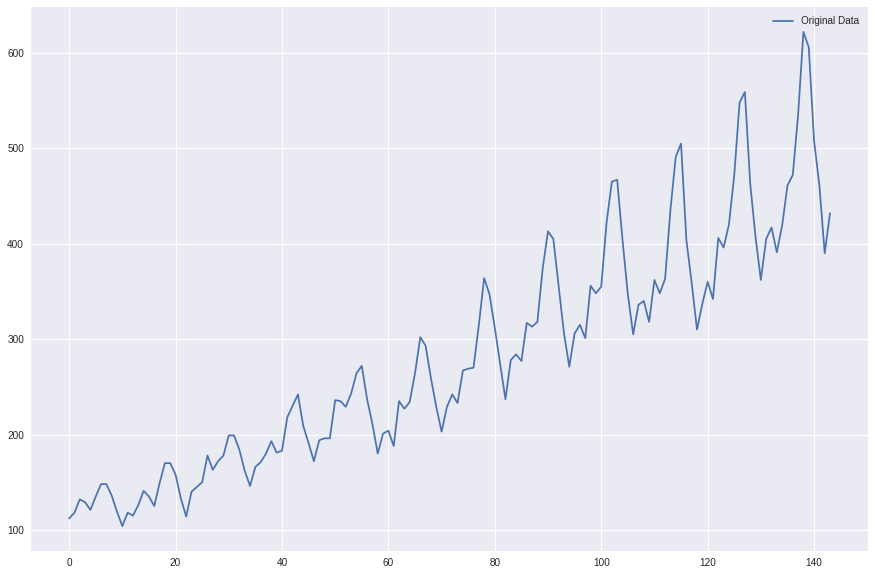

In [7]:
plt.plot(dataset, label='Original Data')
plt.legend()

##Preprocessing the dataset for RNN models

In [0]:
# normalize dataset
scaler = skpp.MinMaxScaler(feature_range=(0, 1))
normailzed_dataset = scaler.fit_transform(dataset)

In [0]:
# train/test sets
train, test = dsu.train_test_split(normailzed_dataset, train_size=0.67)
# convert into supervised learning set of input data and label
n_x = 1 # num of past timesteps used to learn
n_y =1 # num of future timesteps to learn
x_train, y_train, x_test, y_test = dsu.mvts_to_xy(train, test, n_x=n_x, n_y=n_y)

#Simple RNN in TensorFlow

In [0]:
''' parameters '''
# number of weight vectors of an RNN cell
state_size = 4 
# number of x variables
n_x_vars = 1
# number of y variables
n_y_vars = 1
# number of time steps
n_timesteps = n_x

learning_rate = 0.1
n_epochs = 100

In [0]:
tf.reset_default_graph()

Define placeholders,

Shape of x placeholder is `(batch_size, number_of_input_timesteps, number_of_inputs)`

Shape of y placeholder is `(batch_size, number_of_output_timesteps, number_of_outputs)`

Set `batch_size` to `None` so we can input the batch of any size.

In [0]:
x_p = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='x_p')
y_p = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='y_p')

Transform the input placeholder `x_p` into a list of tensors of length equal to the number of time steps,

In [0]:
# make a list of tensors of length n_x
rnn_inputs = tf.unstack(x_p,axis=1)

Create a simple RNN cell,

In [0]:
cell = tf.nn.rnn_cell.BasicRNNCell(state_size)

TensorFlow provides the `static_rnn` and `dynamic_rnn` convenience methods
(among others) to create a static and dynamic RNN respectively.

In [0]:
rnn_outputs, final_state = tf.nn.static_rnn(cell, rnn_inputs, dtype=tf.float32)

Static RNN creates the cells, i.e. unrolls the loop, at the compile time. Dynamic
RNN creates the cells, namely unrolls the loop, at the runtime.

The `static_rnn` method takes the following parameters:
* `cell`: The basic RNN cell object that we defined earlier. It could be another kind
of cell.
* `rnn_inputs`: The list of Tensors of shape ``(batch_size, number_of_inputs)`.
* `dtype`: The data type of initial state and expected outputs.

In [0]:
# weights, biases
W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

Define the predictions layer as a dense linear layer:

In [59]:
predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]
print(predictions)

[<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>]


Convert output y tensor to a list

In [60]:
y_as_list = tf.unstack(y_p, num=n_timesteps, axis=1)
print(y_as_list)

[<tf.Tensor 'unstack_1:0' shape=(?, 1) dtype=float32>]


Losses and Optimizr:

In [0]:
mse = tf.losses.mean_squared_error
losses = [mse(labels=label, predictions=prediction) 
               for prediction, label in zip(predictions, y_as_list)]

total_loss = tf.reduce_sum(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

Training and Evaluating,

In [62]:
with tf.Session() as tfs:
  tfs.run(tf.global_variables_initializer())
  epoch_loss = 0.0
  for epoch in range(n_epochs):
    feed_dict = {x_p: x_train.reshape(-1, n_timesteps, n_x_vars),
                 y_p: y_train.reshape(-1, n_timesteps, n_y_vars)}
    
    epoch_loss, y_train_pred, _ = tfs.run([total_loss, predictions, optimizer],
                                       feed_dict=feed_dict
                                      )
    
  print('train mse = {}'.format(epoch_loss))
  
  feed_dict = {x_p: x_test.reshape(-1, n_timesteps, n_x_vars),
               y_p: y_test.reshape(-1, n_timesteps, n_y_vars)}
  test_loss, y_test_pred = tfs.run([total_loss, predictions],
                                   feed_dict=feed_dict
                                  )
  print('test mse = {}'.format(test_loss))
  print('test rmse = {}'.format(np.sqrt(test_loss)))

train mse = 0.001979885855689645
test mse = 0.010242714546620846
test rmse = 0.10120629519224167


This was a very simple case of predicting one time step ahead with just
one variable value. In real life, the output is influenced by more than one
feature and it is required to predict more than one time step ahead. The
latter kind of problems are called *multivariate multi-time-step-ahead
forecasting* problems.

We can plot the graph,

In [0]:
# y_train_pred is a list of one entry containing the np.array of prediction
# need to extract out of the python list
y_train_pred = y_train_pred[0]
y_test_pred = y_test_pred[0]

In [0]:
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

Text(0,0.5,'Total Passengers')

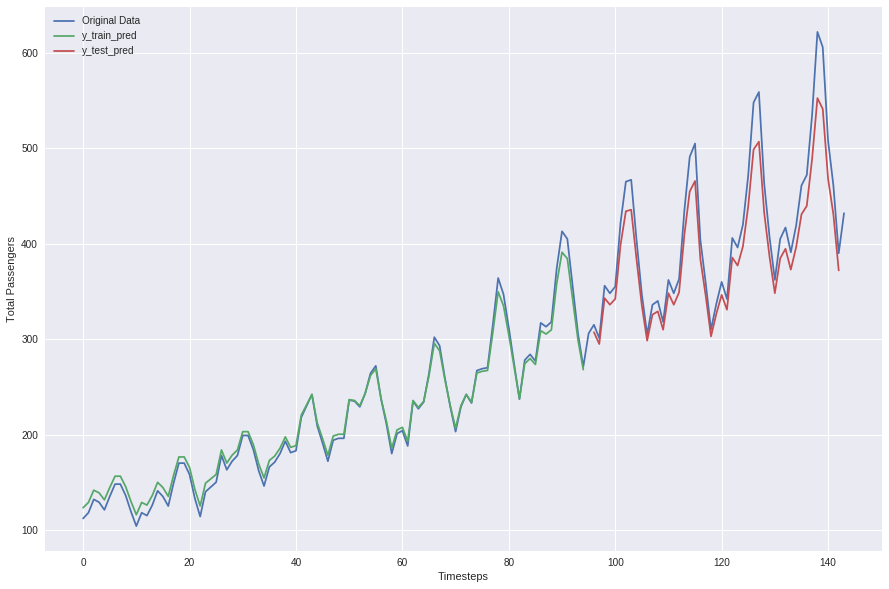

In [70]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :] = y_test_pred

# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')

#LSTM in TensorFlow

In [0]:
n_epochs = 600
n_timesteps = n_x   # number of time steps
n_x_vars = 1  # number of x variables
n_y_vars = 1  # number of y variables
learning_rate = 0.1

In [0]:
tf.reset_default_graph()

In [0]:
x_p = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='x_p') 
y_p = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='y_p')

# make a list of tensors of length n_x
rnn_inputs = tf.unstack(x_p,axis=1)

Use `LSTMCell` here,

In [0]:
cell = tf.nn.rnn_cell.LSTMCell(state_size)

In [0]:
rnn_outputs, final_state = tf.nn.static_rnn(cell, rnn_inputs,dtype=tf.float32)

In [0]:
W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

y_as_list = tf.unstack(y_p, num=n_timesteps, axis=1)

mse = tf.losses.mean_squared_error
losses = [mse(labels=label, predictions=prediction) for 
          prediction, label in zip(predictions, y_as_list)
         ]
total_loss = tf.reduce_sum(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)


In [88]:
with tf.Session() as tfs:
  tfs.run(tf.global_variables_initializer())
  epoch_loss = 0.0
  for epoch in range(n_epochs):
    feed_dict = {x_p: x_train.reshape(-1, n_timesteps, n_x_vars),
                 y_p: y_train.reshape(-1, n_timesteps, n_y_vars)}
    
    epoch_loss, y_train_pred, _ = tfs.run([total_loss, predictions, optimizer],
                                       feed_dict=feed_dict
                                      )
    
  print('train mse = {}'.format(epoch_loss))
  
  feed_dict = {x_p: x_test.reshape(-1, n_timesteps, n_x_vars),
               y_p: y_test.reshape(-1, n_timesteps, n_y_vars)}
  test_loss, y_test_pred = tfs.run([total_loss, predictions],
                                   feed_dict=feed_dict
                                  )
  print('test mse = {}'.format(test_loss))
  print('test rmse = {}'.format(np.sqrt(test_loss)))

train mse = 0.0036644155625253916
test mse = 0.035328835248947144
test rmse = 0.1879596710205078


Text(0,0.5,'Total Passengers')

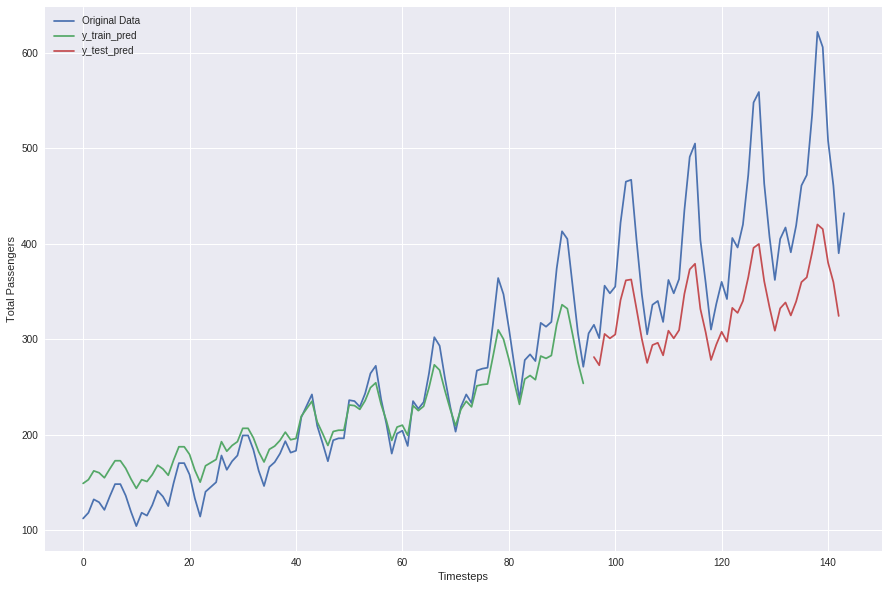

In [89]:
y_train_pred = y_train_pred[0]
y_test_pred = y_test_pred[0]

#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :]=y_test_pred

# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')

#GRU in TensorFlow

In [0]:
state_size = 4
n_epochs = 600
n_timesteps = n_x   # number of time steps
n_x_vars = 1  # number of x variables
n_y_vars = 1  # number of y variables
learning_rate = 0.1

In [0]:
tf.reset_default_graph()
x_p = tf.placeholder(tf.float32, [None, n_timesteps, n_x_vars], name='x_p') 
y_p = tf.placeholder(tf.float32, [None, n_timesteps, n_y_vars], name='y_p')

# make a list of tensors of length n_x
rnn_inputs = tf.unstack(y_p,axis=1)

Add `GRUCell` here,

In [0]:
cell = tf.nn.rnn_cell.GRUCell(state_size)

rnn_outputs, final_state = tf.nn.static_rnn(cell, rnn_inputs,dtype=tf.float32)


In [0]:
W = tf.get_variable('W', [state_size, n_y_vars])
b = tf.get_variable('b', [n_y_vars], initializer=tf.constant_initializer(0.0))

predictions = [tf.matmul(rnn_output, W) + b for rnn_output in rnn_outputs]

y_as_list = tf.unstack(y_p, num=n_timesteps, axis=1)

mse = tf.losses.mean_squared_error
losses = [mse(labels=label, predictions=prediction) for 
          prediction, label in zip(predictions, y_as_list)
         ]
total_loss = tf.reduce_sum(losses)
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)


In [97]:
with tf.Session() as tfs:
  tfs.run(tf.global_variables_initializer())
  epoch_loss = 0.0
  for epoch in range(n_epochs):
    feed_dict = {x_p: x_train.reshape(-1, n_timesteps, n_x_vars),
                 y_p: y_train.reshape(-1, n_timesteps, n_y_vars)}
    
    epoch_loss, y_train_pred, _ = tfs.run([total_loss, predictions, optimizer],
                                       feed_dict=feed_dict
                                      )
    
  print('train mse = {}'.format(epoch_loss))
  
  feed_dict = {x_p: x_test.reshape(-1, n_timesteps, n_x_vars),
               y_p: y_test.reshape(-1, n_timesteps, n_y_vars)}
  test_loss, y_test_pred = tfs.run([total_loss, predictions],
                                   feed_dict=feed_dict
                                  )
  print('test mse = {}'.format(test_loss))
  print('test rmse = {}'.format(np.sqrt(test_loss)))

train mse = 9.615778253646567e-06
test mse = 0.0016221512341871858
test rmse = 0.040275938808918


Text(0,0.5,'Total Passengers')

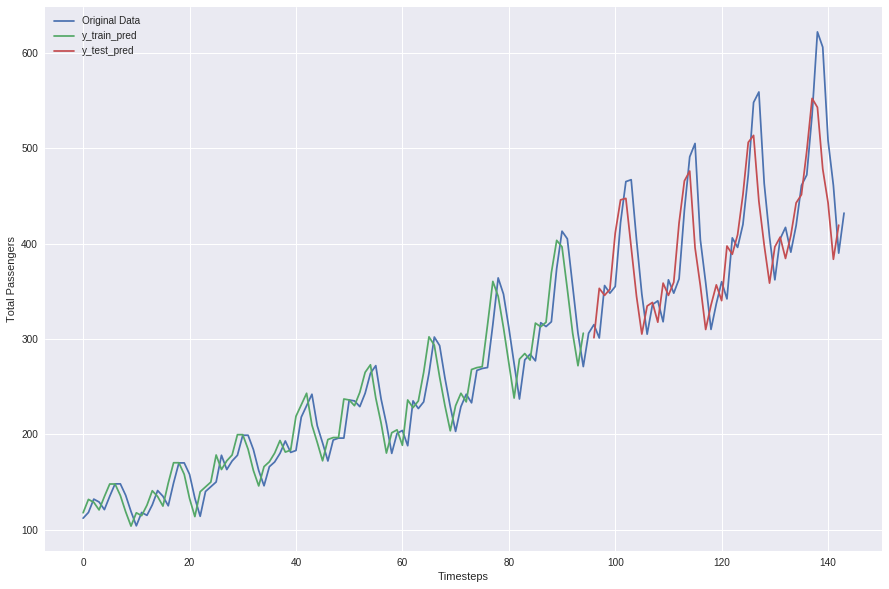

In [98]:
y_train_pred = y_train_pred[0]
y_test_pred = y_test_pred[0]

#invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x-1:len(y_train_pred)+n_x-1, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2)-1:len(dataset)-1, :]=y_test_pred

# plot baseline and predictions
plt.plot(dataset,label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')

##Preprocessing dataset for RNN models in Keras
The data preprocessing process is the same as in TensorFlow unitl getting the supervised machine learning time series datasets: `x_train, y_train, x_test, y_test`.

In [0]:
dataframe = pd.read_csv('./dataset/international-airline-passengers.csv',
                        usecols=[1], header=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = skpp.MinMaxScaler(feature_range=(0, 1))
normalized_dataset = scaler.fit_transform(dataset)

# split into train and test sets
train,test=dsu.train_test_split(normalized_dataset,train_size=0.67)
n_x=1
x_train, y_train, x_test, y_test = dsu.mvts_to_xy(train,test,n_x=n_x,n_y=1)

Then, the input has to be in the shape `(samples, time steps, features)` in Keras.

The `x_train` and `x_test` datasets could be reshaped as one of the following methods:

Method 1: *n* timesteps with *1* feature:

    x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    
Method 2: *1* timesteps with *n* features:

    x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

In [0]:
# reshape input to be [samples, time_steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

#Simple RNN in Keras

`SimpleRNN(units=num_internal_neurons)`

In [9]:
# create and fit the SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
95/95 [==============================] - 1s 8ms/step - loss: 0.0159
Epoch 2/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0074
Epoch 3/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 4/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 5/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0043
Epoch 6/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0036
Epoch 7/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0031
Epoch 8/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0027
Epoch 9/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0024
Epoch 10/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0023
Epoch 11/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0022
Epoch 12/20
95/95 [==============================] - 0s 1ms/step - loss: 0.0021
Epoch 13/20
95/95 [==============================

In [0]:
# make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

In [13]:
# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

Train Score: 23.27 RMSE
Test Score: 54.13 RMSE


Text(0,0.5,'Total Passengers')

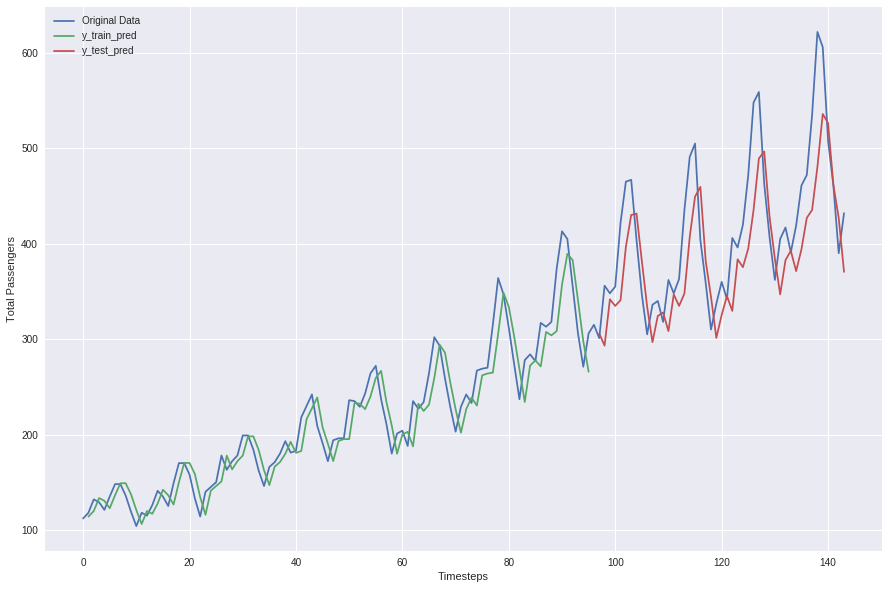

In [14]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred
# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset),:]=y_test_pred
# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')

From the plot, we can see that the hyperparameters need to be tuned to enhance the performance

#LSTM with Keras


In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], 1)

In [17]:
# create and fit the LSTM model
model = Sequential()
model.add(LSTM(units=4, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
95/95 [==============================] - 1s 10ms/step - loss: 0.0550
Epoch 2/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 3/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0205
Epoch 4/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0188
Epoch 5/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0179
Epoch 6/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0168
Epoch 7/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0158
Epoch 8/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0150
Epoch 9/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 10/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0130
Epoch 11/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0120
Epoch 12/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0109
Epoch 13/20
95/95 [=============================

In [0]:
# make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

# invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)

In [20]:
# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

Train Score: 32.22 RMSE
Test Score: 84.70 RMSE


Text(0,0.5,'Total Passengers')

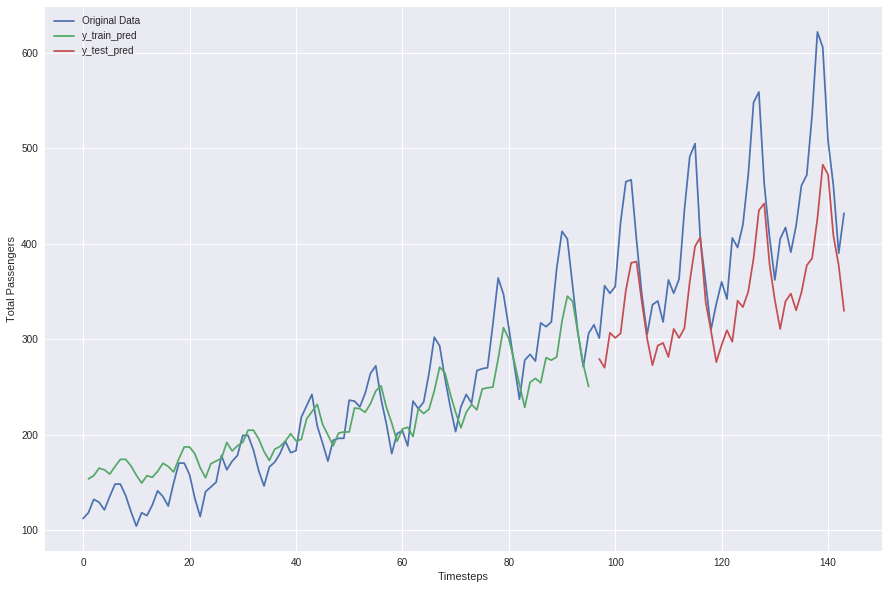

In [21]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')

From the plot, we can see that the hyperparameters need to be tuned to enhance the performance

#GRU with Keras


In [0]:
tf.reset_default_graph()
keras.backend.clear_session()

# reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], 1)

In [24]:
# create and fit the GRU Model
model = Sequential()
model.add(GRU(units=4, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 4)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 77
Trainable params: 77
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1)

Epoch 1/20
95/95 [==============================] - 1s 9ms/step - loss: 0.0535
Epoch 2/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0274
Epoch 3/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0198
Epoch 4/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0178
Epoch 5/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 6/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0159
Epoch 7/20
95/95 [==============================] - 0s 3ms/step - loss: 0.0151
Epoch 8/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 9/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0135
Epoch 10/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0126
Epoch 11/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0118
Epoch 12/20
95/95 [==============================] - 0s 2ms/step - loss: 0.0110
Epoch 13/20
95/95 [==============================

In [0]:
# make predictions
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)
# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

#invert originals
y_train_orig = scaler.inverse_transform(y_train)
y_test_orig = scaler.inverse_transform(y_test)


In [27]:
# calculate root mean squared error
trainScore = k_sqrt(k_mse(y_train_orig[:,0],
                          y_train_pred[:,0])
                   ).eval(session=K.get_session())
print('Train Score: {0:.2f} RMSE'.format(trainScore))
testScore = k_sqrt(k_mse(y_test_orig[:,0],
                         y_test_pred[:,0])
                  ).eval(session=K.get_session())
print('Test Score: {0:.2f} RMSE'.format(testScore))

Train Score: 31.49 RMSE
Test Score: 92.76 RMSE


Text(0,0.5,'Total Passengers')

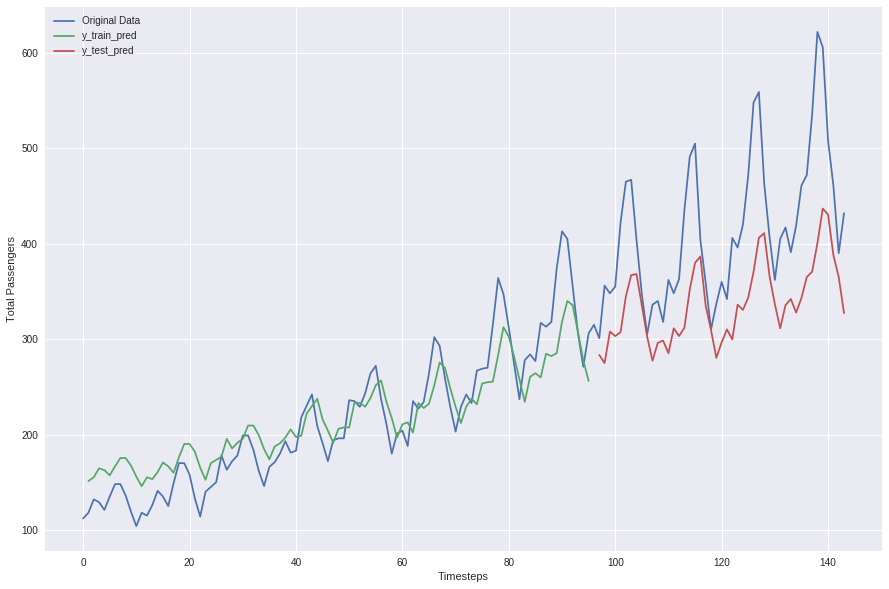

In [28]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(normalized_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_x:len(y_train_pred)+n_x, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(normalized_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+(n_x*2):len(normalized_dataset), :] = y_test_pred

# plot baseline and predictions
plt.plot(scaler.inverse_transform(normalized_dataset),label='Original Data')
plt.plot(trainPredictPlot,label='y_train_pred')
plt.plot(testPredictPlot,label='y_test_pred')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Total Passengers')

The result is pretty bad. We need to further tune the hyperparameters..